In [1]:
# import statements to download census data
import requests
import pandas as pd
from google.colab import files
import json
# loading in necessary modules for shape files
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import urllib3

## To download desired dataset first go to : https://api.census.gov/data/2023/acs/acs5/profile/variables.html

### Find the `Name` code for the desired dataset by pressing `ctrl + F` on your keyboard and paste it in user input box after running the code below.

#### Note: The link provided is from 2023 and ACS 5 year estimates, the nomenclature followed by U.S. Census Bureau remains the same throughout i.e., the naming is the same for a particular dataset even if it is ACS 1 or 3 year estimate or even if the year is different.

# STEP 1

## `Name` column contains the variable code that you would need to manually insert in the prompt to download that specific data for the region you are interested in.

In [2]:
def download_census_data():
    print("Welcome to Census API Downloader for ACS Profile Data")
    print("This script will construct the API URL based on your inputs and download the data as CSV in the Colab workspace.")

    # Input year
    year = input("Enter year (2009-2023, default 2023): ") or "2023"

    # Input ACS type
    acs = input("Enter ACS type (acs1, acs3, acs5, default acs5): ") or "acs5"

    # Input variables
    variables_str = input("Enter variable codes separated by commas (e.g., DP04_0058E,DP03_0062E): ")
    variables = [v.strip() for v in variables_str.split(',') if v.strip()]

    # Always include GEO_ID and NAME
    get_params = "NAME,GEO_ID"
    if variables:
        get_params += "," + ",".join(variables)

    # Input geography level
    level = input("Enter geography level (state, county, tract): ").lower()

    # Input state
    state = input("Enter state FIPS code or * for all (e.g., 18 for Indiana): ") or "*"

    # Input county if needed
    county = "*"
    if level in ['county', 'tract']:
        county = input("Enter county FIPS code or * for all: ") or "*"

    # Input tract if needed
    tract = "*"
    if level == 'tract':
        tract = input("Enter tract code or * for all: ") or "*"

    # Input API key if any
    key = input("Enter your Census API key (optional, press enter if none): ")

    # Build base URL
    base_url = f"https://api.census.gov/data/{year}/acs/{acs}/profile"

    # Build for and in parameters
    for_str = ""
    in_str = ""

    if level == 'state':
        for_str = f"state:{state}"
    elif level == 'county':
        for_str = f"county:{county}"
        if state != '*':
            in_str = f"state:{state}"
    elif level == 'tract':
        for_str = f"tract:{tract}"
        in_str = f"state:{state}"
        if county != '*':
            in_str += f" county:{county}"
        else:
            in_str += " county:*"
    else:
        print("Invalid level. Exiting.")
        return

    # Build full URL with descriptive=true
    url = f"{base_url}?get={get_params}&for={for_str}&descriptive=true"
    if in_str:
        url += f"&in={in_str}"
    if key:
        url += f"&key={key}"

    print(f"\nConstructed URL: {url}")

    # Fetch data
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if not data or len(data) < 2:
            print("No data returned.")
            return

        # Convert to DataFrame
        headers = data[0]
        rows = data[1:]
        df = pd.DataFrame(rows, columns=headers)

        # Save to CSV in Colab's working directory
        csv_filename = f"census_data_{year}_{acs}_{level}.csv"
        df.to_csv(csv_filename, index=False)

        print(f"\nData saved in Colab working directory as: {csv_filename}")
        print("You can load it in the next step using:")
        print(f"df = pd.read_csv('{csv_filename}')")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
    except json.JSONDecodeError:
        print("Invalid JSON response. The API might not support the requested parameters.")
    except Exception as e:
        print(f"An error occurred: {e}")



## Run the full function to download the desired dataset

In [3]:
# Run the function
download_census_data()

Welcome to Census API Downloader for ACS Profile Data
This script will construct the API URL based on your inputs and download the data as CSV in the Colab workspace.
Enter year (2009-2023, default 2023): 
Enter ACS type (acs1, acs3, acs5, default acs5): 
Enter variable codes separated by commas (e.g., DP04_0058E,DP03_0062E): DP04_0058E
Enter geography level (state, county, tract): tract
Enter state FIPS code or * for all (e.g., 18 for Indiana): 17
Enter county FIPS code or * for all: *
Enter tract code or * for all: *
Enter your Census API key (optional, press enter if none): 

Constructed URL: https://api.census.gov/data/2023/acs/acs5/profile?get=NAME,GEO_ID,DP04_0058E&for=tract:*&descriptive=true&in=state:17 county:*

Data saved in Colab working directory as: census_data_2023_acs5_tract.csv
You can load it in the next step using:
df = pd.read_csv('census_data_2023_acs5_tract.csv')


## Now read the downloaded census data file using pandas and analyse the data

In [4]:
df = pd.read_csv('census_data_2023_acs5_tract.csv')

In [5]:
df

,NAME,GEO_ID,DP04_0058E,state,county,tract
0,Geographic Area Name,Geography,Estimate!!VEHICLES AVAILABLE!!Occupied housing...,State,County,Census Tract
1,Census Tract 1; Adams County; Illinois,1400000US17001000100,21,17,001,000100
2,Census Tract 2.01; Adams County; Illinois,1400000US17001000201,65,17,001,000201
3,Census Tract 2.02; Adams County; Illinois,1400000US17001000202,13,17,001,000202
4,Census Tract 4; Adams County; Illinois,1400000US17001000400,296,17,001,000400
...,...,...,...,...,...,...
3261,Census Tract 305.01; Woodford County; Illinois,1400000US17203030501,20,17,203,030501
3262,Census Tract 305.02; Woodford County; Illinois,1400000US17203030502,29,17,203,030502
3263,Census Tract 306.01; Woodford County; Illinois,1400000US17203030601,164,17,203,030601
3264,Census Tract 306.02; Woodford County; Illinois,1400000US17203030602,16,17,203,030602


## Make sure to check column names before perfoming the table join! Check `Data Collection` module for detailed tutorial on spatial joining.

In [6]:
# Create new GEOID column by keeping everything after 'US'
df["GEOID"] = df["GEO_ID"].str.split("US", n=1).str[1]

# Optional: reorder columns so GEOID is right after GEO_ID
cols = list(df.columns)
cols.insert(cols.index("GEO_ID") + 1, cols.pop(cols.index("GEOID")))
df = df[cols]

df.head()

,NAME,GEO_ID,GEOID,DP04_0058E,state,county,tract
0,Geographic Area Name,Geography,NaN,Estimate!!VEHICLES AVAILABLE!!Occupied housing...,State,County,Census Tract
1,Census Tract 1; Adams County; Illinois,1400000US17001000100,17001000100,21,17,001,000100
2,Census Tract 2.01; Adams County; Illinois,1400000US17001000201,17001000201,65,17,001,000201
3,Census Tract 2.02; Adams County; Illinois,1400000US17001000202,17001000202,13,17,001,000202
4,Census Tract 4; Adams County; Illinois,1400000US17001000400,17001000400,296,17,001,000400


# STEP 2

### Hardcoded State FIPS Code to make choosing easier.

In [7]:
# Disable SSL warnings (we're skipping SSL verification)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# === State FIPS lookup ===
fips_to_state = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode Island",
    45: "South Carolina", 46: "South Dakota", 47: "Tennessee", 48: "Texas",
    49: "Utah", 50: "Vermont", 51: "Virginia", 53: "Washington", 54: "West Virginia",
    55: "Wisconsin", 56: "Wyoming"
}

## Download and extract the shape file of desired state.
### Note : You can change the year based on the year you choose in step 1. Make sure the years match in step 1 and 2 since an unmatch can cause some tracts to not be displayed correctly or even missing.
### The below also renames and saves the shape file in a new directory based on the state name. So for example if 18 is chosen, the shape file would be saved in a folder called Indiana_TRACT.  

In [8]:
# === Download & extract shapefile ===
def download_extract_rename_zip_file(number, year=2023):
    base_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/"
    file_name = f"tl_{year}_{number:02d}_tract.zip"
    url = base_url + file_name

    # Download with SSL verification disabled
    try:
        response = requests.get(url, verify=False)
        if response.status_code == 200:
            with open(file_name, 'wb') as file:
                file.write(response.content)
            print(f"Downloaded {file_name}")
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")
            return None, None
    except requests.RequestException as e:
        print(f"Error downloading {file_name}: {e}")
        return None, None

    # Extract ZIP
    extract_folder = file_name[:-4]
    try:
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Extracted {file_name}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting {file_name}: {e}")
        return None, None
    finally:
        try:
            os.remove(file_name)
            print(f"Deleted {file_name}")
        except OSError as e:
            print(f"Error deleting {file_name}: {e}")

    # Rename folder to state name
    state_name = fips_to_state.get(number)
    if state_name:
        new_folder_name = f"{state_name}_TIGER"
        if os.path.exists(new_folder_name):
            shutil.rmtree(new_folder_name)
            print(f"Deleted existing folder {new_folder_name}")
        os.rename(extract_folder, new_folder_name)
        print(f"Renamed to {new_folder_name}")
        return new_folder_name, state_name
    else:
        print(f"No state name found for FIPS {number}")
        return extract_folder, None

### Next Step is to load in and join the Shape file with the Census Data File. We use 'inner' join to include only the rows/tracts that match in both files. You can choose 'outer' to include the ones that cause mismatch as well.

In [9]:
# === Load shapefile and join with census CSV ===
def load_and_join_shapefile(folder_name, number, state_name, census_csv_path, year=2023):
    """Load shapefile, join with census data by GEOID, keep only matches."""
    shp_file = os.path.join(folder_name, f"tl_{year}_{number:02d}_tract.shp")

    if os.path.exists(shp_file):
        gdf = gpd.read_file(shp_file)

        # Load census data
        df_census = pd.read_csv(census_csv_path)
        df_census["GEOID"] = df_census["GEO_ID"].str.split("US", n=1).str[1]

        # Join shapefile with census data
        gdf_joined = gdf.merge(df_census, on="GEOID", how="inner")
        print(f"Merged GeoDataFrame shape: {gdf_joined.shape}")

        # Save merged shapefile
        merged_shp = f"{state_name}_census_tracts_with_data.shp"
        gdf_joined.to_file(merged_shp)
        print(f"Saved merged shapefile: {merged_shp}")

        return gdf_joined
    else:
        print(f"Shapefile not found: {shp_file}")
        return None

## Finally Run the Code to get the file, extract, and merge with census data downloaded in step 1.

In [10]:
# === Example run ===
fips = 17  # Illinois
year = 2023
census_csv_path = "census_data_2023_acs5_tract.csv"  # Path to your previously downloaded census CSV

folder_name, state_name = download_extract_rename_zip_file(fips, year)

# performing the inner merging of shape file (step 2) and census data (step 1)
if folder_name and state_name:
    merged_gdf = load_and_join_shapefile(folder_name, fips, state_name, census_csv_path, year)

Downloaded tl_2023_17_tract.zip
Extracted tl_2023_17_tract.zip
Deleted tl_2023_17_tract.zip
Renamed to Illinois_TIGER
Merged GeoDataFrame shape: (3265, 20)
Saved merged shapefile: Illinois_census_tracts_with_data.shp


### Display the final final

In [11]:
merged_gdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,GEO_ID,DP04_0058E,state,county,tract
0,17,161,022800,17161022800,1400000US17161022800,228,Census Tract 228,G5020,S,2103943,0,+41.4991066,-090.5472913,"POLYGON ((-90.55724 41.49433, -90.55724 41.494...",Census Tract 228; Rock Island County; Illinois,1400000US17161022800,82,17,161,022800
1,17,161,022900,17161022900,1400000US17161022900,229,Census Tract 229,G5020,S,1311568,0,+41.4897868,-090.5477824,"POLYGON ((-90.55731 41.49337, -90.55727 41.493...",Census Tract 229; Rock Island County; Illinois,1400000US17161022900,11,17,161,022900
2,17,161,023000,17161023000,1400000US17161023000,230,Census Tract 230,G5020,S,4680875,127822,+41.4757633,-090.5435406,"POLYGON ((-90.55779 41.46279, -90.55772 41.463...",Census Tract 230; Rock Island County; Illinois,1400000US17161023000,11,17,161,023000
3,17,161,023100,17161023100,1400000US17161023100,231,Census Tract 231,G5020,S,3496624,66115,+41.4684205,-090.5721252,"POLYGON ((-90.5826 41.46694, -90.5826 41.46714...",Census Tract 231; Rock Island County; Illinois,1400000US17161023100,32,17,161,023100
4,17,019,010901,17019010901,1400000US17019010901,109.01,Census Tract 109.01,G5020,S,140475117,118829,+39.9889767,-088.2028522,"POLYGON ((-88.27831 39.88075, -88.27786 39.883...",Census Tract 109.01; Champaign County; Illinois,1400000US17019010901,58,17,019,010901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,17,195,001300,17195001300,1400000US17195001300,13,Census Tract 13,G5020,S,3058885,0,+41.8026590,-089.6673228,"POLYGON ((-89.67947 41.79957, -89.67946 41.800...",Census Tract 13; Whiteside County; Illinois,1400000US17195001300,152,17,195,001300
3261,17,195,000600,17195000600,1400000US17195000600,6,Census Tract 6,G5020,S,352671538,4367544,+41.7023883,-090.0729869,"POLYGON ((-90.24791 41.74694, -90.2479 41.7470...",Census Tract 6; Whiteside County; Illinois,1400000US17195000600,30,17,195,000600
3262,17,195,000800,17195000800,1400000US17195000800,8,Census Tract 8,G5020,S,331559611,1574583,+41.6502472,-089.7773192,"POLYGON ((-89.92104 41.59391, -89.92093 41.593...",Census Tract 8; Whiteside County; Illinois,1400000US17195000800,29,17,195,000800
3263,17,089,850400,17089850400,1400000US17089850400,8504,Census Tract 8504,G5020,S,4478955,609174,+42.0974370,-088.2480785,"POLYGON ((-88.28454 42.10354, -88.28437 42.103...",Census Tract 8504; Kane County; Illinois,1400000US17089850400,148,17,089,850400


## Time to visualize the census dataset itself.

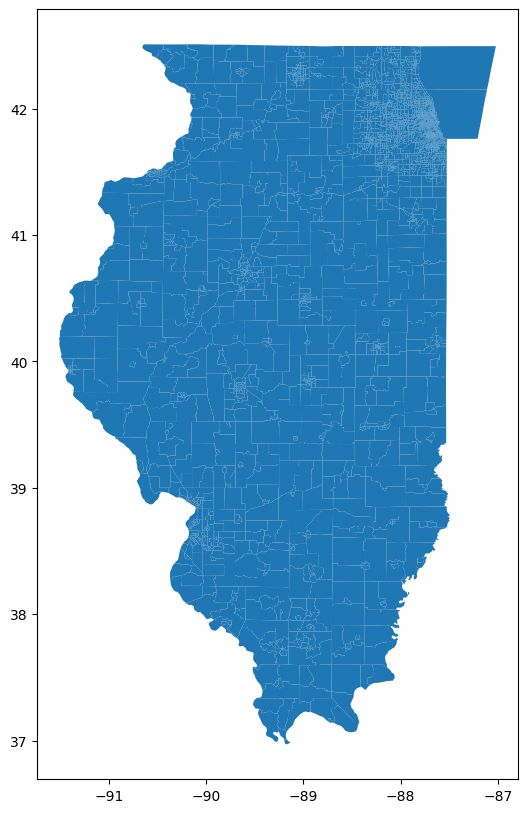

In [12]:
# You can now visualize
merged_gdf.plot(figsize=(10, 10))
plt.show()

<Axes: >

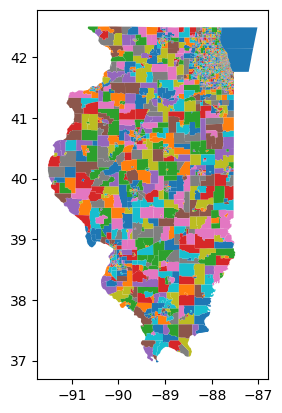

In [13]:
merged_gdf.plot("DP04_0058E")

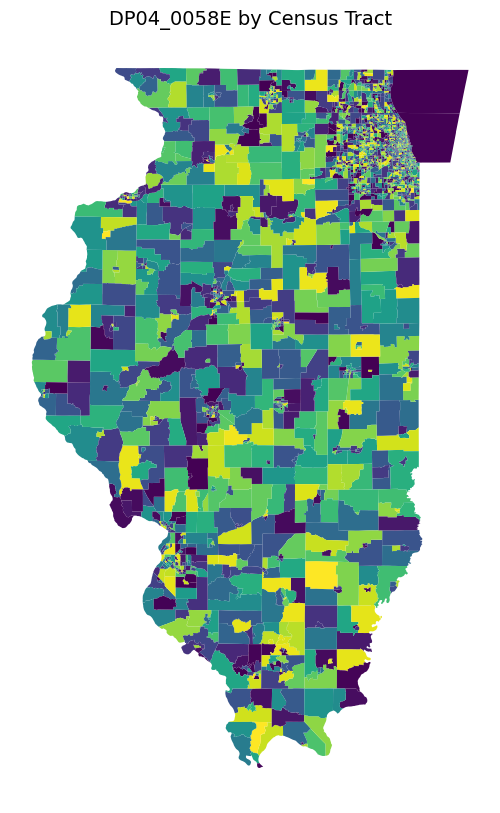

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(
    column="DP04_0058E",   # column to color by
    cmap="viridis",        # color map
    legend=False,           # show color legend
    ax=ax
)
ax.set_title("DP04_0058E by Census Tract", fontsize=14)
ax.axis("off")
plt.show()

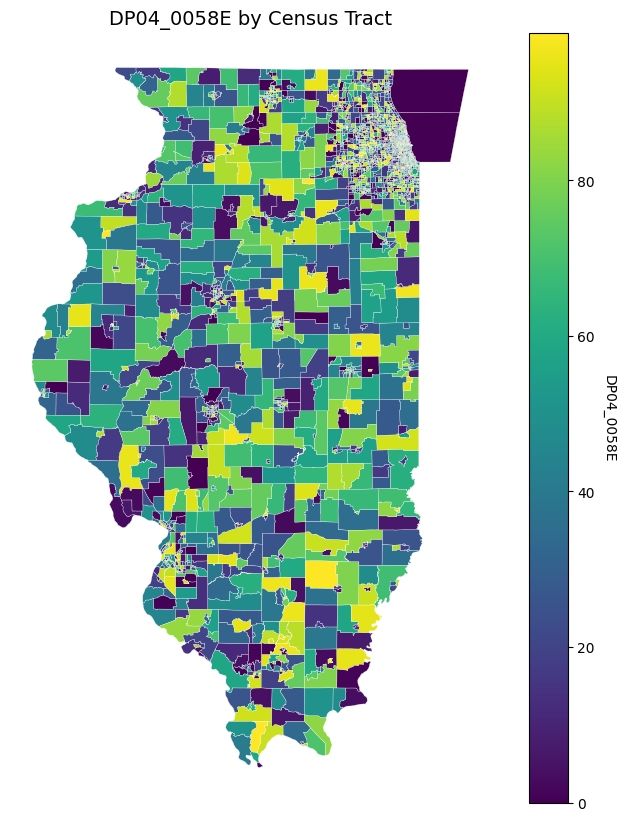

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot without legend so we can add our own colorbar
merged_gdf.plot(
    column="DP04_0058E",
    cmap="viridis",
    linewidth=0.2,
    edgecolor="white",
    ax=ax
)

ax.set_title("DP04_0058E by Census Tract", fontsize=14)
ax.axis("off")

# Create colorbar
sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(
        vmin=merged_gdf["DP04_0058E"].min(),
        vmax=merged_gdf["DP04_0058E"].max()
    )
)
sm._A = []  # For older Matplotlib compatibility
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("DP04_0058E", rotation=270, labelpad=15)

plt.show()